# PROYEK DATA SCIENCE DALAM NLP : DETEKSI SPAM PADA PESAN SMS BERBAHASA INDONESIA


---



## Import Package

### Install Package Sastrawi

In [1]:
!pip install PySastrawi

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# FOR NLP
import re
import spacy
from spacy.lang.id.stop_words import STOP_WORDS
nlp = spacy.blank('id')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import ngrams

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from spacy.lang.id.stop_words import STOP_WORDS
from collections import Counter

# FOR MODELING
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler,FunctionTransformer
from sklearn.naive_bayes import MultinomialNB

plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# About CRISP-DM

Konten proyek ini mengikuti metodologi Cross-Industry Standard Process for Data Mining (CRISP-DM) adapun konten dari notebook ini adalah sebagai berikut:
* Business Understanding : Pendefinisian masalah yang akan diselesaikan dalam proyek ini
* Analytic Approach : Metode yang akan digunakan untuk menyelesaikan masalah yang telah didefinsikan pada bagian Business Understanding
* Data Requirement : Menentukan data yang dibutuhkan untuk menyelesaikan permasalahan tersebut
* Data collection : Mengumpulkan data yang dibutuhkan pada bagian Data Requirement
* Data Understanding : Memahami data yang diperoleh, biasanya menggunakan statistika deskriptif untuk mengenal informasi dari data tersebut
* Data Preparation : Membersihkan data agar dapat dimodelkan oleh model yang telah didefinisikan di analytic approach
* Modeling : Penerapan model untuk menyelesaikan masalah yang diberikan 
* Evaluation : Evaluasi terhadap performa model yang telah dibuat untuk menyelesaikan masalah tersebut, bagian ini krusial untuk menjawab apakah model tersebut perlu dituning atau apakah datanya harus dibersihkan lagi? 
* Deployment : Menerapkan model final sebagai solusi untuk penyelesaian masalah tersebut (bisa dalam bentuk website ataupun se-sederhana blog)
* Feedback : Menerima saran/feedback atas model yang telah dibuat 

Untuk notebook ini akan dijelaskan hingga bagian deployment yakni di blog Medium, 
Berikut adalah ilustrasi proses CRISP-DM

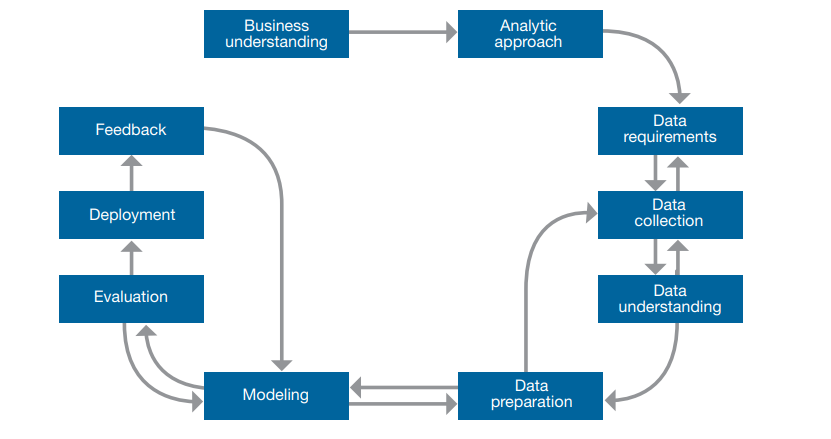

## Business Understanding

Sebagian besar dari kita pasti memiliki telepon genggam/HP. Di dalamnya terdapat fitur pesan SMS yang berisi pesan-pesan penting seperti pengumuman terkait COVID-19 yang diumumkan oleh instansi Kementerian Kesehatan, iklan terkait promo dari layanan yang kita gunakan ataupun pesan dari rekan kita apabila ia tidak menggunakan WhatsApp. 

Namun, seiring waktu pesan spam yang masuk di SMS kita semakin banyak, pesan-pesan hadiah menggiurkan seperti jackpot Rp 100 juta, mobil gratis dan lain-lain tentu menarik perhatian pengguna dan apabila tidak cermat maka ada kemungkinan pengguna tersebut ditipu. 

Lantas, bagaimana caranya untuk dapat mendeteksi pesan SMS mana saja yang termasuk spam? Proyek ini ditujukan untuk membangun suatu model machine learning yang dapat memprediksi apakah suatu pesan SMS mengandung pesan spam

## Analytic Approach

Untuk menentukan bahwa suatu pesan SMS termasuk spam, maka perlu kita proses teks SMS dengan menggunakan Natural Language Processing (NLP) agar dapat diubah menjadi format teks yang lebih sederhana dan Text Vectorizer untuk mengubah teks menjadi angka numerik karena beberapa model machine learning seperti Regresi Logistik, Naive Bayes, dsb TIDAK DAPAT BEKERJA untuk data yang mengandung teks. 

Terakhir, untuk memprediksi sentimen pada pesan SMS, maka kita perlu model machine learning klasifikasi seperti 
* Regresi Logistik
* Naive Bayes
* SVM
* Recurrent Neural Network (tidak akan dibahas dalam hal ini)

Selanjutnya, akan dibandingkan performa dari ketiga model tersebut serta menentukan model yang terbaik dalam memprediksi sentimen. Kita juga dapat mengevaluasi kembali proses data cleaningnya serta memperbaharui model.

## Data Requirement

Data yang dibutuhkan adalah data yang berisi pesan SMS beserta sentimennya

## Data Collection

Data yang diperoleh berasal dari 

https://github.com/kmkurn/id-nlp-resource

Di github tersebut juga tersedia beberapa dataset yang dapat kalian gunakan untuk text mining dan tugas NLP lainnya. Dalam hal ini, akan digunakan data SMS Spam 

## Data Understanding

Sebelum kita melakukan analisis data, hal paling krusial yang harus dilakukan adalah memahami data yang diberikan.
Mari kita lihat konten data yang telah diperoleh,


In [92]:
# Import data
data = pd.read_csv('dataset_sms_spam_v1.csv')

In [93]:
data.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


Di data tersebut terdapat dua kolom yakni teks beserta label, untuk arti labelnya adalah:
* 0 : Pesan SMS biasa 
* 1 : Pesan penipuan/fraud
* 2 : Pesan promo

In [94]:
data.shape

(1143, 2)

Data ini memiliki 1143 baris dan 2 kolom 

In [95]:
data.describe()

,label
count,1143.000000
mean,0.711286
std,0.790001
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,2.000000


Secara umum, karena label bernilai diskrit (bilangan bulat) maka informasi mean, standar deviasi dan kuartil tidak mengandung makna apa-apa 

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


Syukurnya, tidak ada null values dalam data tersebut, jadi kita dapat langsung masuk ke bagian Exploratory Data Analysis

### Exploratory Data Analysis

Pertama, untuk memudahkan visualisasi, kita petakan label tersebut menjadi teks sebagai berikut

In [97]:
# Definisikan kamus untuk label
kamus = {0: 'sms normal',1: 'fraud atau penipuan',2: 'promo'}
data['Sentiment'] = data.label.apply(lambda x: kamus.get(x))

In [98]:
data.head()

,Teks,label,Sentiment
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo


Voila, kini ada 1 fitur tambahan yang dapat memudahkan 

#### Jumlah Sentiment

Pada bagian ini, akan dihitung jumlah pesan yang mengandung sentimen tertentu

In [99]:
# Menghitung jumlah sentiment untuk tiap kategori
cm = sns.light_palette("green", as_cmap=True)
sent_count = data.groupby('Sentiment')['Teks'].count().reset_index().sort_values(by = 'Teks', ascending = False)
sent_count.style.background_gradient(cmap = 'Purples')

,Sentiment,Teks
2,sms normal,569
0,fraud atau penipuan,335
1,promo,239


Paling banyak didominasi oleh pesan bersentimen normal

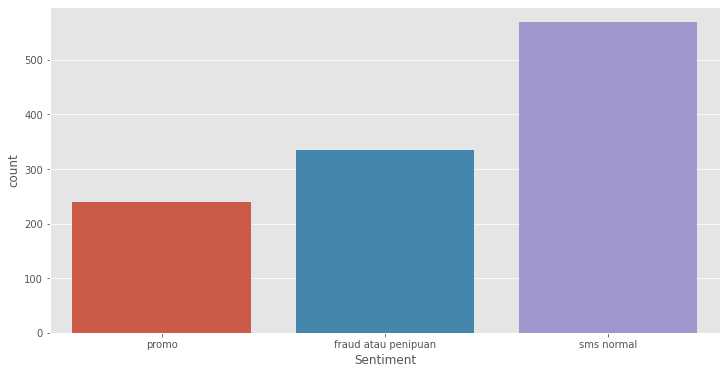

In [100]:
plt.figure(figsize = (12, 6))
sns.countplot(x = 'Sentiment', data = data)
plt.show()

#### Jumlah Huruf
Pada bagian ini akan dilihat distribusi jumlah huruf yang ada di setiap sentimen

In [101]:
def char_count(sentence):
  sentence = sentence.replace(" ","")
  return len(sentence)

data['char_count'] = data['Teks'].apply(char_count)

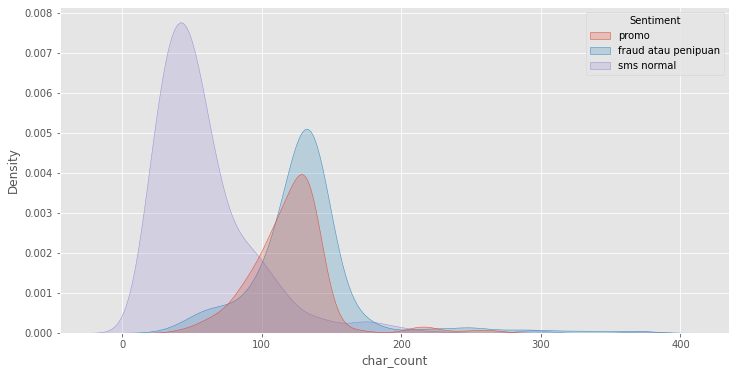

In [102]:
plt.figure(figsize = (12,6))
sns.kdeplot(x = 'char_count', hue = 'Sentiment', shade = True, data = data)
plt.show()

Rata-rata sentiment yang berbau penipuan memiliki 100-200 huruf

In [103]:
data['char_count'].describe().to_frame()

,char_count
count,1143.000000
mean,92.974628
std,51.178256
min,10.000000
25%,49.000000
50%,95.000000
75%,130.000000
max,373.000000


Paling sedikit terdapat 13 huruf sementara paling banyak terdapat 434 huruf. Rata-rata huruf yang digunakan ada 109 huruf

#### Jumlah Kata

Pada bagian ini akan dihitung jumlah kata yang ada di setiap sentimen

In [104]:
def word_count(sentence):
  sentence = sentence.split()
  return len(sentence)

data['word_count'] = data['Teks'].apply(word_count)

In [105]:
data.head()

,Teks,label,Sentiment,char_count,word_count
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18


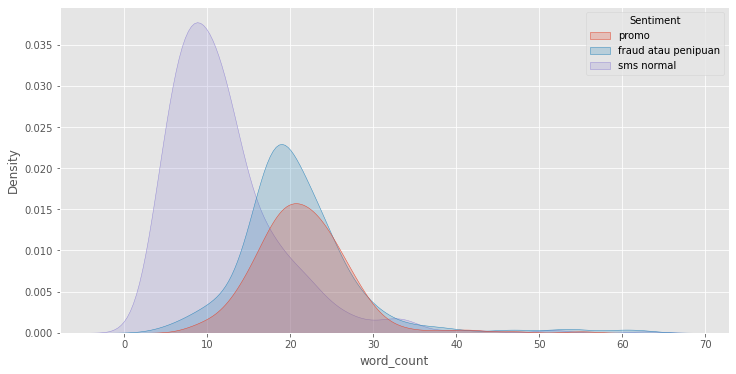

In [106]:
plt.figure(figsize = (12,6))
sns.kdeplot(x = 'word_count', hue = 'Sentiment', shade = True, data = data)
plt.show()

Bisa dilihat terdapat perbedaan yang khas antara sentiment berbau fraud, promo dan sms normal

In [107]:
data['word_count'].describe().to_frame()

,word_count
count,1143.000000
mean,16.687664
std,8.439519
min,2.000000
25%,10.000000
50%,17.000000
75%,22.000000
max,63.000000


Minimal kata yang digunakan ada 2 kata, maksimal terdapat 63 kata, rata-rata terdapat 17 kata

## Data Preparation

Kita masuk ke bagian Data Preparation. Perlu diingat bahwa proses ini adalah salah satu proses tersulit dan terpanjang dalam pemodelan data science. Tapi jangan takut dulu, pada data preparation ini akan dijelaskan dengan bahasa yang lebih mudah dipahami

### Text Cleaning

#### Analisis Teks

In [108]:
data[data["Sentiment"] == "fraud atau penipuan"]

,Teks,label,Sentiment,char_count,word_count
239,"Jika anda bermasalah dgn CC/KT@, stres dgn bun...",1,fraud atau penipuan,104,16
240,"Lelah byr min payment? Kami Solusinya, bantu s...",1,fraud atau penipuan,121,17
241,"Dana Tunai (KTA) bunga 0,99% hingga 300 jt. Sy...",1,fraud atau penipuan,123,28
242,“ROXI CELL” Hanya dengan Rp.100rb Anda bisa ja...,1,fraud atau penipuan,139,21
243,3 RAMADHAN Selamat Anda Pemenang Rp.100jt. PIN...,1,fraud atau penipuan,90,11
...,...,...,...,...,...
569,Yth Bpk/Ibu. BNI menyatakan Rekening anda terp...,1,fraud atau penipuan,128,19
570,Yth Isti Sofiyah. Diminta Segera Hubungi Bpk D...,1,fraud atau penipuan,129,23
571,YTH kpd bpk/ibu sy Eka Novitasari kariyawan 3c...,1,fraud atau penipuan,285,49
572,"YTH,MIitra Silahkan cek poin anda dan tukarkan...",1,fraud atau penipuan,89,16


In [109]:
data['Teks'][243]

'3 RAMADHAN Selamat Anda Pemenang Rp.100jt. PIN CODE 7Y7R8K9Z Info: www.hadiah-3ramadhan.blogspot.com   '

In [110]:
data['Teks'][2]

'2016-07-08 11:47:11.Plg Yth, sisa kuota Flash Anda 478KB. Download MyTelkomsel apps di http://tsel.me/tsel utk cek kuota&beli paket Flash atau hub *363#'

In [111]:
data.Teks[1136]

'Yg ragu sm bulet/datar atau yg pgn ikutan debat kusir :v'

In [112]:
data.head()

,Teks,label,Sentiment,char_count,word_count
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18


In [113]:
data.Teks[0]

'[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K'

In [114]:
kalimat = data.Teks.iloc[1].lower()

In [115]:
kalimat

'2.5 gb/30 hari hanya rp 35 ribu spesial buat anda yang terpilih. aktifkan sekarang juga di *550*905#. promo sd 30 nov 2015.buruan aktifkan sekarang. s&k'

In [116]:
# Uji Coba Regular Expression
kal_baru = re.sub(r'\w*\.*\w{1,}\.*\/\w{1,}','',kalimat)
kal_baru

'2.5  hari hanya rp 35 ribu spesial buat anda yang terpilih. aktifkan sekarang juga di *550*905#. promo sd 30 nov 2015.buruan aktifkan sekarang. s&k'

In [117]:
def bersih_bersih(sentence):
  '''Membuat kalimat menjadi huruf kecil semua, menghilangkan clickbait seperti [PROMO], tanggal di awal SMS, jumlah tarif, pulsa'''

  sentence = sentence.lower()
  sentence = re.sub(r'(\[.*?\]|\(.*?\))','',sentence) #menghilangkan kata-kata dalam kurung 

  sentence = re.sub(r'\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}\.','',sentence) #menghilangkan format tanggal dan waktu
  sentence = re.sub(r'\d{2}\s\w{3,}\s\d{4}.','', sentence) #Menghilangkan format tanggal "XX NAMA BULAN TAHUN"

  sentence = re.sub(r'(menit|mnt|thn|tahun|minggu|mg|hari|hr|jam|jm|detik|dtk|sekon)*','', sentence) #Menghilangkan satuan waktu
  sentence = re.sub(r'(\d{1,}\s*gb|\d{1,}\s*kb|\d{1,}\s*mb|\d{1,}\s*tb|lte)',"", sentence) #Menghilangkan satuan byte dan kata lte
  sentence = re.sub(r'(ribu|rb|jt|juta|milyar|miliar|triliun|trilyun)',"", sentence) # Menghilangkan satuan uang

  sentence = re.sub(r'\w*\.*\w{1,}\.*\/\w{1,}','',sentence) #Menghilangkan pecahan
  sentence = re.sub(r'rp\s*\d{1,}\s','',sentence) # Menghilangkan jumlah tarif

  sentence = re.sub(r"\*\d{3,}\*\d{3,}\#","", sentence) # Menghilangkan kode aktivasi-1
  sentence = re.sub(r"\*\d{3,}\#","", sentence) #Menghilangkan kode aktivasi-2

  sentence = re.sub(r"https?://\S*|www\.\S+","", sentence) #Menghilangkan web
  sentence = re.sub(r'(\d{1,}\.*\d{0,})','', sentence) #Menghilangkan angka 
  sentence = sentence.strip()

  return sentence


In [118]:
data['Teks Bersih'] = data['Teks'].apply(bersih_bersih)

In [119]:
data[['Teks','Teks Bersih']]

,Teks,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,beli paket flash mulai di my telkomsel app dp...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,hanya spesial buat anda yang terpilih. aktifk...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...","plg yth, sisa kuota flash anda . download myte..."
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...","plg yth, sisa kuota flash anda . download myte..."
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,hanya spesial buat anda yang terpilih. aktifk...
...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas","yooo sama, oke nanti aku umumin di grup kelas"
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,😁 sebelumnya ga ad nulis kerudung. kirain warn...
1140,Mba mau kirim 300 ya,mba mau kirim ya
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,nama beaok bwrangkat pagi...mau cas atay tran...


In [120]:
data.Teks[0]

'[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K'

In [121]:
data.tail(10)

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
1133,Yg butuh kosan perbulan bisa langsung ditempat...,0,sms normal,190,33,yg butuh kosan peulan bisa langsung ditempatin...
1134,"Yg dian ge waktu itu yudisium akhirnya sore2, ...",0,sms normal,92,18,"yg dian ge waktu itu yudisium akhirnya sore, g..."
1135,Yg mau ngampus aku pengen titip bawain SKL aku...,0,sms normal,46,11,yg mau ngampus aku pengen titip bawain skl aku...
1136,Yg ragu sm bulet/datar atau yg pgn ikutan deba...,0,sms normal,46,11,yg ragu sm atau yg pgn ikutan debat kusir :v
1137,Yg sebelah warteg bahri apa sebrangnya? Yg 15,0,sms normal,38,8,yg sebelah warteg bai apa sebrangnya? yg
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,sms normal,38,9,"yooo sama, oke nanti aku umumin di grup kelas"
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,sms normal,44,9,😁 sebelumnya ga ad nulis kerudung. kirain warn...
1140,Mba mau kirim 300 ya,0,sms normal,16,5,mba mau kirim ya
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,sms normal,44,7,nama beaok bwrangkat pagi...mau cas atay tran...
1142,No bri atas nama kamu mana,0,sms normal,21,6,no bri atas nama kamu mana


In [122]:
data["Teks Bersih"][240]

'lelah byr min payment? kami solusinya, bantu secara legal penutupan , dscn -%. hub.lolyta  . legal'

#### Remove Stopwords

In [123]:
STOP_WORDS.update(['yg','jg','teh','mah','da','atuh','jd','km','ak','lg','ya','ga','ngga','nggak','gak','tp',
                   'kalo','nya','pake','liat','udh','aja','wkwk','wkwkwk','wk','gt','gais','blm','sih','tau',
                   'tahu','gt','udah','utk','rb','rp','dgn','ayo','isi','biar','yah','dr','bawa','gitu','eh',
                   'pas','td','sm','pengen','pgn','dpt','sd','byr','min','dscn','sy','no'])

In [124]:
def remove_stopwords(sentence):
  words = sentence.split()
  words = [word for word in words if word not in STOP_WORDS and word.isalpha()]
  return " ".join(words)

In [125]:
data['Teks Bersih'] = data['Teks Bersih'].apply(remove_stopwords)

In [126]:
data[['Teks','Teks Bersih']]

,Teks,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,beli paket flash my telkomsel app extra kuota ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,spesial aktifkan promo buruan aktifkan
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",plg sisa kuota flash download mytelkomsel apps...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",plg sisa kuota flash download mytelkomsel apps...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,spesial aktifkan skb
...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",yooo oke umumin grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,ad nulis kirain warna jins
1140,Mba mau kirim 300 ya,mba kirim
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,nama beaok bwrangkat cas atay


In [127]:
data['Teks'][240]

'Lelah byr min payment? Kami Solusinya, bantu secara LEGAL penutupan CC/KTA, dscn 50-75%. Hub.LoLyta 081316523061/087822962308 (WA). LEGAL'

In [128]:
data['Teks Bersih'][243]

'ramadhan selamat pemenang pin code yrkz'

#### Lemmatizer

In [129]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [130]:
def lemmatizer(sentence):
  output = stemmer.stem(sentence)
  return output

data['Teks Bersih'] = data['Teks Bersih'].apply(lemmatizer)

In [131]:
data.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26,beli paket flash my telkomsel app extra kuota ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25,spesial aktif promo buru aktif
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21,plg sisa kuota flash download mytelkomsel apps...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21,plg sisa kuota flash download mytelkomsel apps...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18,spesial aktif skb


In [132]:
data.tail(10)

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
1133,Yg butuh kosan perbulan bisa langsung ditempat...,0,sms normal,190,33,butuh kosan peulan langsung lokasi gang sampin...
1134,"Yg dian ge waktu itu yudisium akhirnya sore2, ...",0,sms normal,92,18,dian ge yudisium dibarengin nondik sampe yudisium
1135,Yg mau ngampus aku pengen titip bawain SKL aku...,0,sms normal,46,11,ngampus titip bawain skl
1136,Yg ragu sm bulet/datar atau yg pgn ikutan deba...,0,sms normal,46,11,ragu ikut debat kusir
1137,Yg sebelah warteg bahri apa sebrangnya? Yg 15,0,sms normal,38,8,belah warteg bai
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,sms normal,38,9,yooo oke umumin grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,sms normal,44,9,ad nulis kirain warna jins
1140,Mba mau kirim 300 ya,0,sms normal,16,5,mba kirim
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,sms normal,44,7,nama beaok bwrangkat cas atay
1142,No bri atas nama kamu mana,0,sms normal,21,6,bri nama


In [133]:
data['Teks Bersih'][243]

'ramadhan selamat menang pin code yrkz'

#### Frekuensi Kata

Setelah ini akan dilihat frekuensi kata dari data teks bersih untuk setiap kategori

In [134]:
def word_frequency(sentence):
  sentence = " ".join(sentence)
  new_tokens = word_tokenize(sentence)
  counted = Counter(new_tokens)
  word_freq = pd.DataFrame(counted.items(), columns = ['Kata','Frekuensi']).sort_values(by = 'Frekuensi',ascending = False)
  return word_freq

In [135]:
def wordcloud(sentence, title):
  sentence = " ".join(sentence)
  WC = WordCloud(background_color = 'white', max_words= 500, max_font_size = 100)
  cloud = WC.generate(sentence)
  plt.imshow(cloud, interpolation = "bilinear")
  plt.title(title)
  plt.axis("off")
  plt.show()

In [137]:
data.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26,beli paket flash my telkomsel app extra kuota ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25,spesial aktif promo buru aktif
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21,plg sisa kuota flash download mytelkomsel apps...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21,plg sisa kuota flash download mytelkomsel apps...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18,spesial aktif skb


In [138]:
data['Sentiment'].unique()

array(['promo', 'fraud atau penipuan', 'sms normal'], dtype=object)

##### Bagi-bagi data

In [139]:
promos = data[data['Sentiment'] == 'promo'].reset_index().drop('index',axis = 1)
sms_normal = data[data['Sentiment'] == 'sms normal'].reset_index().drop('index',axis = 1)
fraud = data[data['Sentiment'] == 'fraud atau penipuan'].reset_index().drop('index',axis = 1)

In [140]:
top_20_kata_promo = word_frequency(promos['Teks Bersih'])[:20]
top_20_kata_fraud = word_frequency(fraud['Teks Bersih'])[:20]
top_20_kata_sms_normal = word_frequency(sms_normal['Teks Bersih'])[:20]
semua_senti_20 = word_frequency(data['Teks Bersih'])[:20]

###### Pesan Keseluruhan

In [141]:
promos.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26,beli paket flash my telkomsel app extra kuota ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25,spesial aktif promo buru aktif
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21,plg sisa kuota flash download mytelkomsel apps...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21,plg sisa kuota flash download mytelkomsel apps...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18,spesial aktif skb


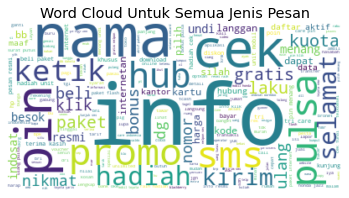

In [142]:
wordcloud(data['Teks Bersih'], "Word Cloud Untuk Semua Jenis Pesan")

In [143]:
semua_senti_20
semua_senti_20.style.background_gradient(cmap = 'BuGn')

,Kata,Frekuensi
70,info,125
302,hadiah,119
524,pin,102
10,cek,98
62,sms,94
1,paket,93
128,nama,86
23,pulsa,85
110,menang,77
835,resmi,69


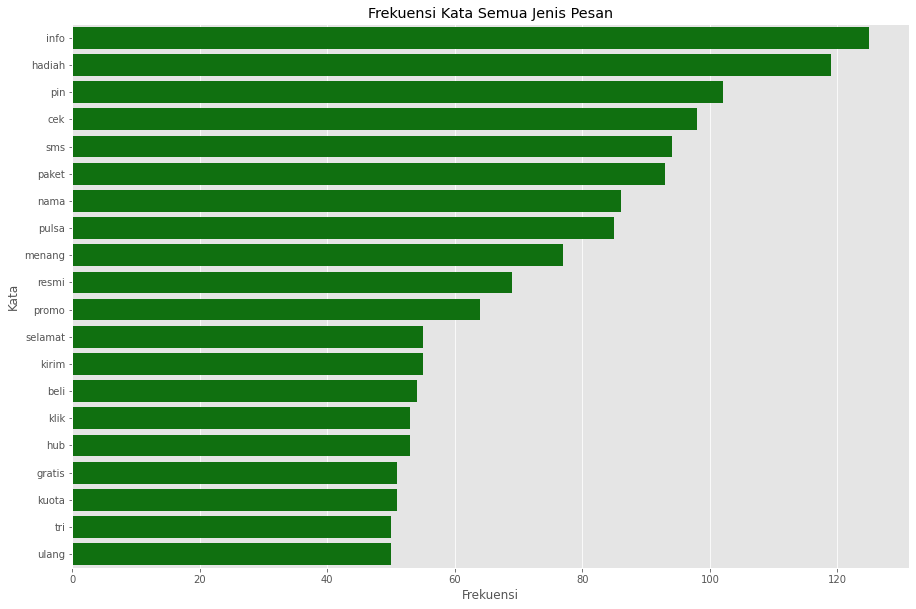

In [144]:
plt.figure(figsize = (15,10))
sns.barplot(x = 'Frekuensi', y = 'Kata', data = semua_senti_20, color = 'green')
plt.title("Frekuensi Kata Semua Jenis Pesan")
plt.show()

Kata yang sering muncul berkaitan dengan hadiah ataupun pesan resmi dari provider 

###### Pesan Normal

In [145]:
sms_normal.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,Di kfc yg deket enhaii ada dy,0,sms normal,23,7,kfc deket enhaii dy
1,"Maaf jika ada janji yang belum terpenuhi, jik...",0,sms normal,69,13,maaf janji janji
2,*ngsih bunga ato coklat min,0,sms normal,23,5,bunga ato coklat
3,.sambl nunggu itu.. Gimana kalo ngerjain form ...,0,sms normal,53,10,nunggu gimana ngerjain form formnya
4,[Akademik] Untuk perhatian tuk jadwal kontrak ...,0,sms normal,293,52,perhati tuk jadwal kontrak kuliah ang kuliah j...


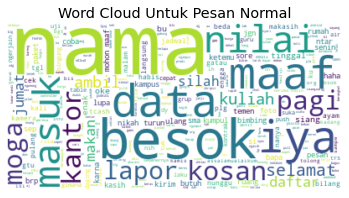

In [146]:
wordcloud(sms_normal['Teks Bersih'], "Word Cloud Untuk Pesan Normal")

In [147]:
top_20_kata_sms_normal
top_20_kata_sms_normal.style.background_gradient(cmap = 'Blues')

,Kata,Frekuensi
80,nama,85
141,besok,23
4,maaf,22
760,iya,15
41,data,15
701,masuk,13
289,nilai,13
129,pagi,12
514,kosan,12
333,kantor,12


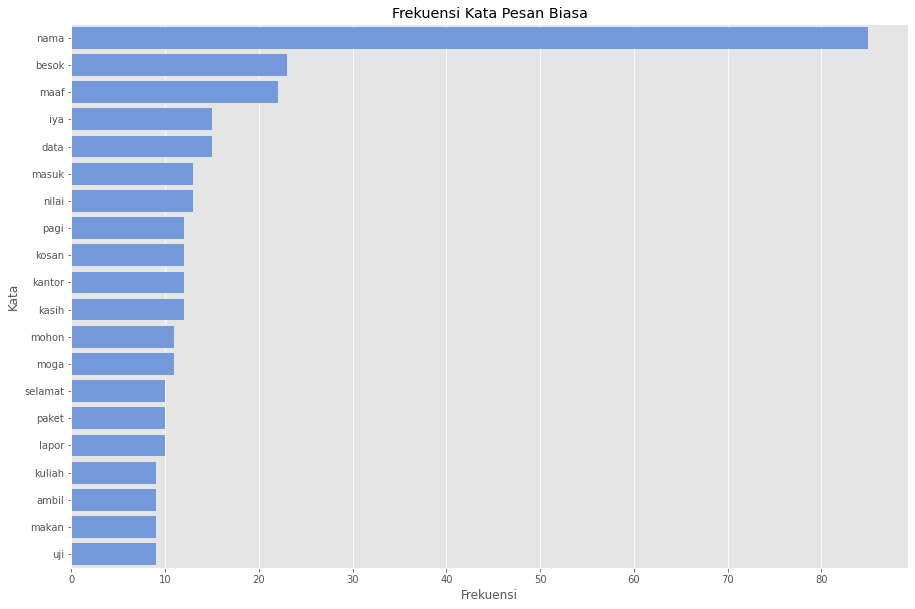

In [148]:
plt.figure(figsize = (15,10))
sns.barplot(x = 'Frekuensi', y = 'Kata', data = top_20_kata_sms_normal, color = 'cornflowerblue')
plt.title("Frekuensi Kata Pesan Biasa")
plt.show()

Pesan Normal SMS cenderung berisi tentang aktivitas yang dilakukan seorang

###### Pesan Penipuan

In [149]:
fraud.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,"Jika anda bermasalah dgn CC/KT@, stres dgn bun...",1,fraud atau penipuan,104,16,masalah stres lunas disc aty legal
1,"Lelah byr min payment? Kami Solusinya, bantu s...",1,fraud atau penipuan,121,17,lelah bantu legal tutup legal
2,"Dana Tunai (KTA) bunga 0,99% hingga 300 jt. Sy...",1,fraud atau penipuan,123,28,dana tunai bunga syarat ktp bpkb rate cair hub...
3,“ROXI CELL” Hanya dengan Rp.100rb Anda bisa ja...,1,fraud atau penipuan,139,21,agen pulsa elektrik operator daftar ketik mtro...
4,3 RAMADHAN Selamat Anda Pemenang Rp.100jt. PIN...,1,fraud atau penipuan,90,11,ramadhan selamat menang pin code yrkz


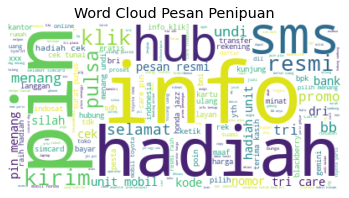

In [150]:
wordcloud(fraud['Teks Bersih'], 'Word Cloud Pesan Penipuan')

In [151]:
top_20_kata_fraud
top_20_kata_fraud.style.background_gradient(cmap = 'Reds')

,Kata,Frekuensi
150,hadiah,117
32,pin,98
92,info,85
31,menang,73
210,resmi,69
153,cek,50
215,klik,48
380,care,47
137,tri,46
101,sms,43


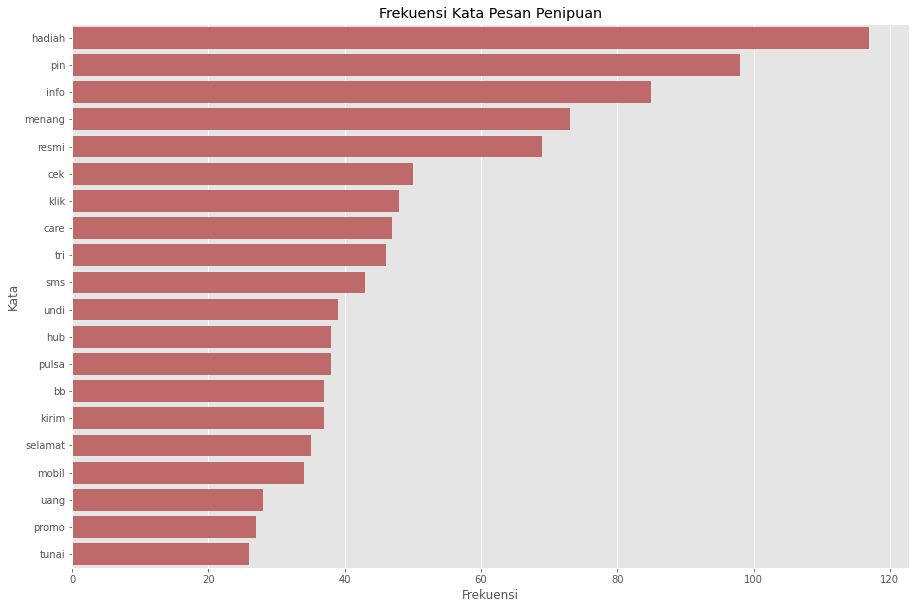

In [152]:
plt.figure(figsize = (15,10))
sns.barplot(x = 'Frekuensi', y = 'Kata', data = top_20_kata_fraud, color = 'indianred')
plt.title("Frekuensi Kata Pesan Penipuan")
plt.show()

Kata-kata yang sering muncul dalam pesan penipuan adalah hadiah, pin, info, pemenang serta benda-benda mewah seperti mobil, uang jutaan, dan lain-lain

###### Pesan Promo

In [153]:
promos.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26,beli paket flash my telkomsel app extra kuota ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25,spesial aktif promo buru aktif
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21,plg sisa kuota flash download mytelkomsel apps...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21,plg sisa kuota flash download mytelkomsel apps...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18,spesial aktif skb


In [154]:
top_20_kata_promo
top_20_kata_promo.style.background_gradient(cmap = 'Oranges')

,Kata,Frekuensi
1,paket,82
7,kuota,50
0,beli,49
62,sms,47
10,cek,42
23,pulsa,42
54,bonus,40
57,gratis,37
44,ketik,37
13,promo,36


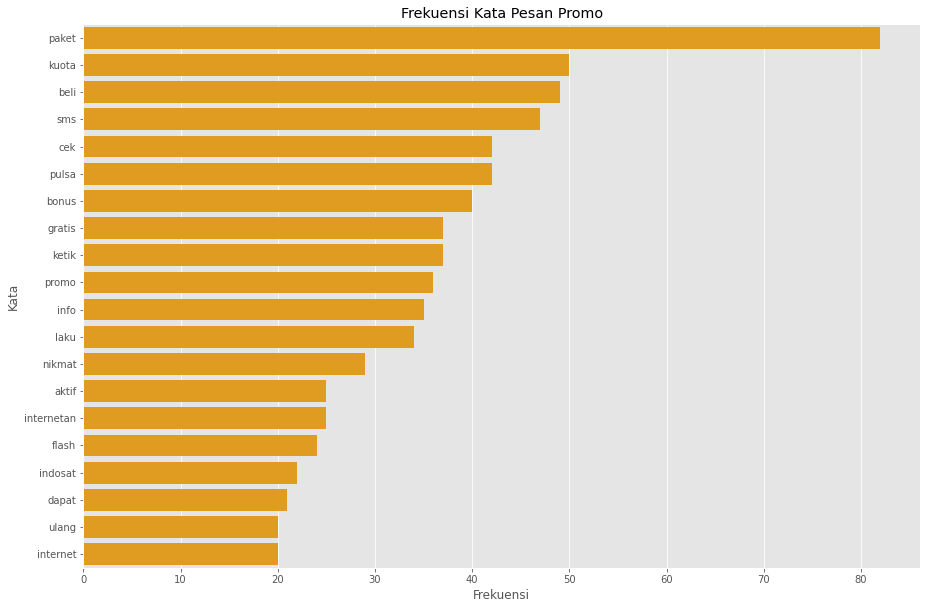

In [155]:
plt.figure(figsize = (15,10))
sns.barplot(x = 'Frekuensi', y = 'Kata', data = top_20_kata_promo, color = 'orange')
plt.title("Frekuensi Kata Pesan Promo")
plt.show()

Kata-kata yang sering muncul pada pesan promo adalah kata paket, kuota, sms, cek, pulsa, dan kata-kata yang berkaitan dengan tawaran promo pulsa ataupun internet oleh provider

## Modeling

### Text Prediction

Akan dilakukan prediksi sentiment dengan data teks yang telah dibersihkan, percobaan pertama akan menggunakan model ML seperti Logistic Regression, Naive Bayes dan Linear SVC. Untuk vectorizernya akan digunakan TfidfVectorizer

#### Split Data

In [156]:
data.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26,beli paket flash my telkomsel app extra kuota ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25,spesial aktif promo buru aktif
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21,plg sisa kuota flash download mytelkomsel apps...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21,plg sisa kuota flash download mytelkomsel apps...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18,spesial aktif skb


Untuk mereduksi 2 kolom numerik menjadi 1 kolom numerik, maka definisikan fitur baru bernama avg_word_length yakni jumlah huruf dari setiap teks dibagi dengna jumlah kata dari setiap teks

In [157]:
data['avg_word_length'] = data['char_count']/data['word_count']

Karena teks, sentimen, char_count dan word_count merupakan fitur yang redundant, maka drop dari data tersebut

In [158]:
data.drop(['Teks','Sentiment','char_count','word_count'], axis = 1, inplace = True)

In [159]:
data.head()

,label,Teks Bersih,avg_word_length
0,2,beli paket flash my telkomsel app extra kuota ...,4.884615
1,2,spesial aktif promo buru aktif,5.120000
2,2,plg sisa kuota flash download mytelkomsel apps...,6.285714
3,2,plg sisa kuota flash download mytelkomsel apps...,6.333333
4,2,spesial aktif skb,5.333333


In [160]:
data.columns

Index(['label', 'Teks Bersih', 'avg_word_length'], dtype='object')

In [161]:
X = data.drop('label',axis = 1)
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 111, stratify = y)

In [162]:
#Buat fungsi untuk mengambil data bertipe teks
get_text_data = FunctionTransformer(lambda x: x['Teks Bersih'], validate = False)

# Buat fungsi untuk mengambil data bertipe numerik
get_numeric_data = FunctionTransformer(lambda x: x[['avg_word_length']], validate = False)

#### Pemodelan Machine Learning

Pada bagian ini akan dilakukan pemodelan machine learning. Terdapat beberapa fungsi yang mungkin kalian baru tau,
* Pipeline : fungsi ini digunakan untuk melakukan proses pemodelan machine learning secara langsung, sehingga tidak perlu mengkode satu-satu
* TfidfVectorizer : Salah satu algoritma text vectorizer untuk mengubah teks menjadi angka dengan mempertimbangkan persentase kemunculan kata tersebut, 
* FeatureUnion : Digunakan untuk menggabung 2 pipeline menjadi sebuah pipeline 
* RandomizedSearchCV : Fungsi untuk memilih parameter yang secara random memberikan performa terbaik

##### Regresi Logistik

In [163]:

numeric_pipe = Pipeline([('selector', get_numeric_data),
                   ('scaler', StandardScaler())])

text_pipe = Pipeline([('selector', get_text_data),
                        ('vectorizer', TfidfVectorizer())])

pl_1 = Pipeline([('union', FeatureUnion([('numeric',numeric_pipe),
                                         ('text', text_pipe)])),
                 ('clf', LogisticRegression())])

In [164]:
#
param_grid_logreg = {'union__text__vectorizer__ngram_range':((1,1),(1,2),(2,2)),
              'clf__tol':(1e-7, 1e-6,1e-5,1e-4,1e-3,1e-2,1e-1),
              'clf__C':(0.01, 0.05, 0.1, 0.5, 0.9, 1.0, 1.5, 2.0, 2.5),
              }

logreg_cv = RandomizedSearchCV(pl_1, param_grid_logreg, cv = 3)

In [165]:
logreg_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('union',
                                              FeatureUnion(transformer_list=[('numeric',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function <lambda> at 0x7f11f518ac20>)),
                                                                                              ('scaler',
                                                                                               StandardScaler())])),
                                                                             ('text',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function <lambda> at 0x7f11

In [166]:
logreg_cv.best_params_

{'clf__C': 2.5,
 'clf__tol': 0.1,
 'union__text__vectorizer__ngram_range': (1, 1)}

In [167]:
logreg_cv.best_score_

0.9012653356237035

Dihasilkan akurasi sebesar 90.1%, yang mana merupakan hasil yang bagus, akan dilihat lebih lanjut confusion matrixnya

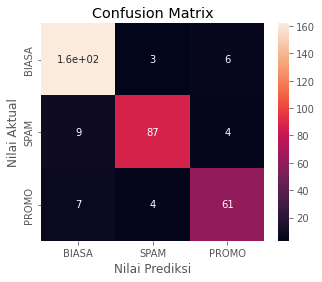

In [173]:
y_pred = logreg_cv.predict(X_test)
cm_logreg = confusion_matrix(y_test, y_pred)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_logreg_df = pd.DataFrame(cm_logreg,
                     index = ['BIASA','SPAM','PROMO'], 
                     columns = ['BIASA','SPAM','PROMO'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_logreg_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Nilai Aktual')
plt.xlabel('Nilai Prediksi')
plt.show()

Arti heatmap ini adalah :
* Model berhasil memprediksi secara benar 162 pesan biasa, namun 3 pesan biasa diprediksi spam dan 6 pesan biasa diprediksi promo
* Model berhasil memprediksi secara benar 87 pesan spam, namun 9 pesan spam diprediksi biasa dan 4 pesan spam diprediksi promo
* Model berhasil memprediksi secara benar 61 pesan promo, namun 7 pesan promo diprediksi biasa dan 4 pesan promo diprediksi spam

##### Naive Bayes

In [174]:
numeric_pipe_nb = Pipeline([('selector', get_numeric_data),
                   ('scaler', MinMaxScaler())])
pl_2 = Pipeline([('union', FeatureUnion([('numeric',numeric_pipe_nb),
                                         ('text', text_pipe)])),
                 ('clf', MultinomialNB())])

In [175]:
param_grid_nb = {'union__text__vectorizer__ngram_range':((1,1),(1,2),(2,2)),
              'clf__alpha':(0.01, 0.05, 0.1, 0.5, 0.9, 1.0, 1.5, 2.0, 2.5)
              }

nb_cv = RandomizedSearchCV(pl_2, param_grid_nb, cv = 3)

In [176]:
nb_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('union',
                                              FeatureUnion(transformer_list=[('numeric',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function <lambda> at 0x7f11f518ac20>)),
                                                                                              ('scaler',
                                                                                               MinMaxScaler())])),
                                                                             ('text',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function <lambda> at 0x7f11f5

In [177]:
nb_cv.best_params_

{'clf__alpha': 0.5, 'union__text__vectorizer__ngram_range': (1, 2)}

In [178]:
nb_cv.best_score_

0.9062731735706308

Akurasi yang dihasilkan lebih tinggi dibandingkan Logistic Regression, dengan Naive Bayes diperoleh 90.5% akurasi. Lebih lanjut lagi, mari kita lihat confusion matrixnya

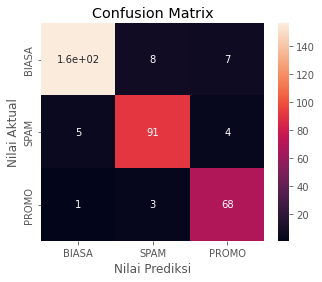

In [179]:
y_pred = nb_cv.predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_nb_df = pd.DataFrame(cm_nb,
                     index = ['BIASA','SPAM','PROMO'], 
                     columns = ['BIASA','SPAM','PROMO'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_nb_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Nilai Aktual')
plt.xlabel('Nilai Prediksi')
plt.show()

Arti heatmap ini adalah :
* Model berhasil memprediksi secara benar **162 pesan biasa**, namun 8 pesan biasa diprediksi spam dan 7 pesan biasa diprediksi promo
* Model berhasil memprediksi secara benar **91 pesan spam**, namun 5 pesan spam diprediksi biasa dan 4 pesan spam diprediksi promo. Lebih rendah, kegagalan prediksinya dibanding model regresi logistik.
* Model berhasil memprediksi secara benar **68 pesan promo**, namun 1 pesan promo diprediksi biasa dan 3 pesan promo diprediksi spam

##### Linear SVC

In [180]:
pl_3 = Pipeline([('union', FeatureUnion([('numeric',numeric_pipe),
                                         ('text', text_pipe)])),
                 ('clf', LinearSVC())])


In [181]:
param_grid_svc = {'union__text__vectorizer__ngram_range':((1,1),(1,2),(2,2)),
              'clf__tol':(1e-7, 1e-6,1e-5,1e-4,1e-3,1e-2,1e-1),
              'clf__C':(0.01, 0.05, 0.1, 0.5, 0.9, 1.0, 1.5, 2.0, 2.5),
              }

svc_cv = RandomizedSearchCV(pl_3, param_grid_svc, cv = 3)

In [ ]:
svc_cv.fit(X_train, y_train)

In [183]:
svc_cv.best_params_

{'clf__C': 2.0,
 'clf__tol': 0.0001,
 'union__text__vectorizer__ngram_range': (1, 2)}

In [184]:
svc_cv.best_score_

0.9137685036561441

Akurasi yang dihasilkan oleh Linear SVC lebih tinggi dibandingkan dengan Logistic Regression dan Naive Bayes. Lebih lanjut lagi, mari kita lihat confusion matrixnya

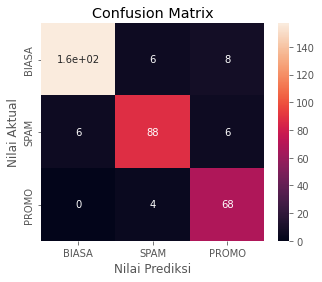

In [186]:
y_pred = svc_cv.predict(X_test)
cm_svc = confusion_matrix(y_test, y_pred)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_svc_df = pd.DataFrame(cm_svc,
                     index = ['BIASA','SPAM','PROMO'], 
                     columns = ['BIASA','SPAM','PROMO'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_svc_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Nilai Aktual')
plt.xlabel('Nilai Prediksi')
plt.show()

Arti heatmap ini adalah :
* Model berhasil memprediksi secara benar **162 pesan biasa**, namun 6 pesan biasa diprediksi spam dan 8 pesan biasa diprediksi promo
* Model berhasil memprediksi secara benar **88 pesan spam**, namun 6 pesan spam diprediksi biasa dan 6 pesan spam diprediksi promo. Lebih rendah, kegagalan prediksinya dibanding model regresi logistik.
* Model berhasil memprediksi secara benar **61 pesan promo**, namun 4 pesan promo diprediksi spam

#### RNN

Akan digunakan metode deep learning RNN untuk melakukan prediksi spam dari dataset yang diberikan, referensi model yang digunakan merujuk ke https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91

##### Mengubah array data teks menjadi array numerik 2D

In [ ]:
X = data['Teks Bersih']
y = data['label']


y = pd.Categorical(y)
y = y.codes

# Import to_categorical from keras utils module
from tensorflow.keras.utils import to_categorical

y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 111, stratify = y)


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers


max_len = max([len(s.split()) for s in X_train])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
encoded_docs = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(encoded_docs, maxlen = max_len, padding = 'post')

encoded_docs_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(encoded_docs_test, maxlen = max_len, padding = 'post')



##### Model RNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()

# Vocab Size
vocab_size = len(tokenizer.index_word) + 1

# Embedding Layer
model.add(Embedding(vocab_size, 150, input_length = max_len))

# LSTM layer
model.add(LSTM(15, dropout = 0.5))

# Another Hidden Layer
model.add(Dropout(0.5))

# Output layer
model.add(Dense(3, activation = 'softmax'))

# Compile model
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Save the best model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor = 'val_accuracy', verbose = 1, save_best_only = True,
                             )

# Fit the model
history = model.fit(X_train,y_train, epochs = 70, validation_data = (X_test, y_test), callbacks = [checkpoint])

Epoch 1/70
24/25 [===========================>..] - ETA: 0s - loss: 1.0494 - accuracy: 0.4935
Epoch 00001: val_accuracy improved from -inf to 0.49854, saving model to best_model.hdf5
25/25 [==============================] - 8s 117ms/step - loss: 1.0478 - accuracy: 0.4963 - val_loss: 1.0320 - val_accuracy: 0.4985
Epoch 2/70
24/25 [===========================>..] - ETA: 0s - loss: 1.0440 - accuracy: 0.4870
Epoch 00002: val_accuracy did not improve from 0.49854
25/25 [==============================] - 1s 48ms/step - loss: 1.0407 - accuracy: 0.4913 - val_loss: 1.0104 - val_accuracy: 0.4985
Epoch 3/70
25/25 [==============================] - ETA: 0s - loss: 0.8234 - accuracy: 0.6137
Epoch 00003: val_accuracy improved from 0.49854 to 0.72886, saving model to best_model.hdf5
25/25 [==============================] - 1s 36ms/step - loss: 0.8234 - accuracy: 0.6137 - val_loss: 0.6130 - val_accuracy: 0.7289
Epoch 4/70
25/25 [==============================] - ETA: 0s - loss: 0.5652 - accuracy: 0.75

##### Plot Loss

In [ ]:
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

def plot_accuracy(acc,val_acc):
  # Plot training & validation accuracy values
  plt.figure()
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

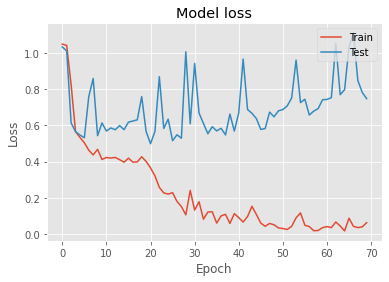

In [ ]:
# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

##### Plot Accuracy

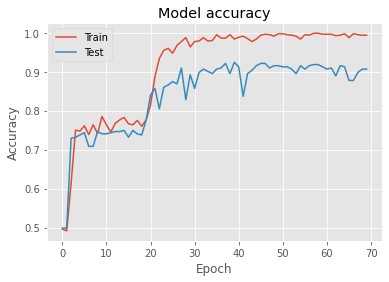

In [ ]:
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

## Evaluation

Untuk meringkas kembali, diperoleh akurasi ketiga model sebagai berikut:
- Regresi Logistik : 90.1%
- Naive Bayes : 90.5%
- SVM : 91.37%

Terdapat perbedaan yang tipis dari ketiga model tersebut, namun jika kita melihat kembali confusion matrixnya, model Naive Bayes memiliki lebih sedikit prediksi yang salah terhadap pesan spam. Kita tentu memilih model Naive Bayes untuk menekan kemungkinan kesalahan prediksi bahwa pesan spam teridentifikasi sebagai pesan biasa atau pesan promo. 

Untuk evaluasi lebih lanjut, kita dapat lebih intensif dalam pembersihan datanya terutama penghilangan kata-kata yang tak baku akan sangat membantu performa model dalam mengidentifikasi kata-kata khas dari setiap sentimen

### Apakah performa model meningkat jika lebih banyak data yang digunakan?

In [ ]:
initial_weights = model.get_weights()
train_accs = []
test_accs = []
training_sizes = [ 125,  502,  879, 1255]
early_stop = EarlyStopping(monitor = 'loss', patience = 1)

In [ ]:
for size in training_sizes:
  	# Get a fraction of training data (we only care about the training data)
    X_train_frac, y_train_frac = X_train[:size], y_train[:size]

    # Reset the model to the initial weights and train it on the new training data fraction
    model.set_weights(initial_weights)
    model.fit(X_train_frac, y_train_frac, epochs = 50, callbacks = [early_stop], verbose = 0)

    # Evaluate and store both: the training data fraction and the complete test set results
    train_accs.append(model.evaluate(X_train, y_train)[1])
    test_accs.append(model.evaluate(X_test, y_test)[1])

11/11 [==============================] - 0s 5ms/step - loss: 0.9575 - accuracy: 0.8863


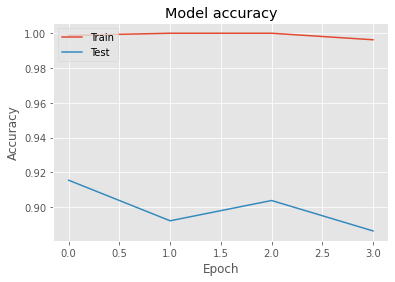

In [ ]:
# Plot train vs test accuracies
plot_accuracy(train_accs, test_accs)

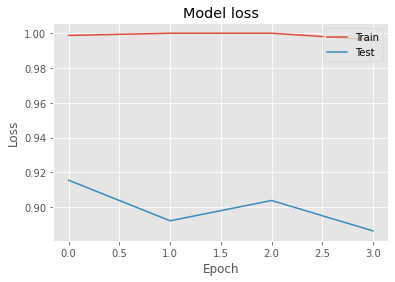

In [ ]:
plot_loss(train_accs, test_accs)

Sepertinya jumlah data yang digunakan tidak terlalu berpengaruh pada model yang digunakan

# Penutup

Sekian penjelasan proyek yang saya kerjakan, adapun penjelasan lebih lanjut beserta kodenya dapat dilihat di:
* Medium (https://kakazidane2000.medium.com/analisis-sentimen-pesan-sms-berbahasa-indonesia-9244ffe70653)
* GitHub (https://github.com/Andikazidanef15/Sentiment-Analysis-on-Indonesian-SMS-Dataset)

Referensi pengerjaan juga saya lihat dari link Kaggle berikut :    
https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model